# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2021

Some, Freddy, 1930443

Nguyen, Huy Viet, 2136374

Note finale :

 <u>**Date limite de remise :**</u>  21 Février 23h59 (Groupe B1), 13 février 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [1]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

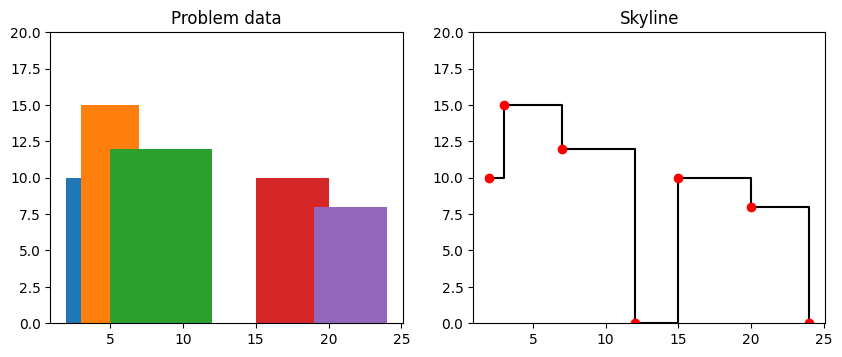

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse. 


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [3]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
import time
from scipy.stats import linregress

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()
    

def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()

## Partie 1 : Algorithme naïf (brute force) (5 pts)

### Implantation

In [5]:
L = 0  # côté gauche
R = 1  # côté droit
H = 2  # hauteur

<u>**Question 1.a):**</u> Implantez un algorithme naïf pour le problème de la ligne d'horizon.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

In [6]:
def skyline_bruteforce(buildings):
    # TODO : Implantez un algorithme naïf
    skyline = []
    sides = []
    
    for building in buildings:
        sides.append(building[L])
        sides.append(building[R])
    sides.sort()

    previous_highest_building = (0, 0, 0)
    
    for side in sides:
        current_highest_building = (0, 0, 0)
        for building in buildings:
            if building[L] <= side and building[R] > side:                
                if building[H] > current_highest_building[H]:
                    current_highest_building = building

        if previous_highest_building != current_highest_building:
            previous_highest_building = current_highest_building
            skyline.append((side, current_highest_building[H]))
    
    return skyline

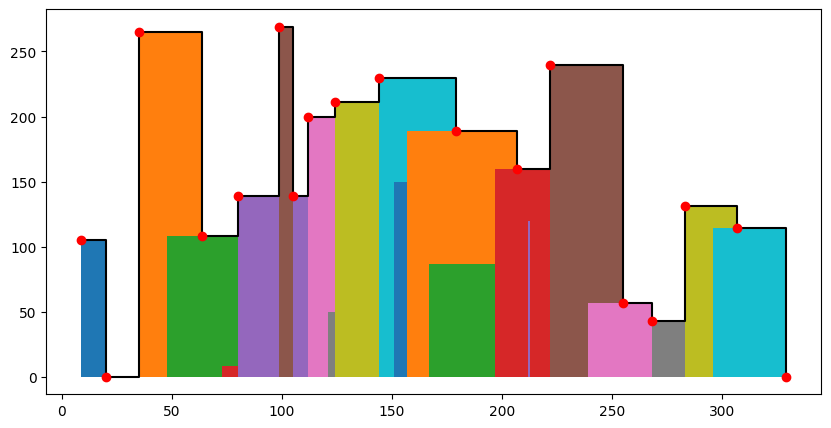

In [15]:
test_bruteforce = generate_sample(20)

verification_plot(test_bruteforce, skyline_bruteforce(test_bruteforce))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

Pour un nombre n de bâtiments, cet algorithme effectue une boucle sur les bâtiments pour créer une liste de bords (en O(n)) et après un trie de la liste (en O(n*logn)). Ensuite, il trouve les points de la ligne d'horizon en exécutant deux boucles imbriquées qui va, pour chaque bord (au total 2n bords), itérer sur tous les bâtiments, ce qui est en O(2n) * O(n) = O(n^2). Donc, la complexité de l'algorithme est de O($n +nlogn + n^2$) = O($n^2$).

### Mesures

In [7]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2136374, [128, 188, 256, 434, 612, 818, 1024, 1536, 2048, 3078, 4096])

In [8]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [9]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
128          0.0021857738494873045
188          0.004595613479614258
256          0.006772565841674805
434          0.01829228401184082
612          0.03709859848022461
818          0.0689997673034668
1024         0.10420775413513184
1536         0.257991886138916
2048         0.45422730445861814
3078         0.9716285705566406
4096         1.7522848129272461


### Analyse hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

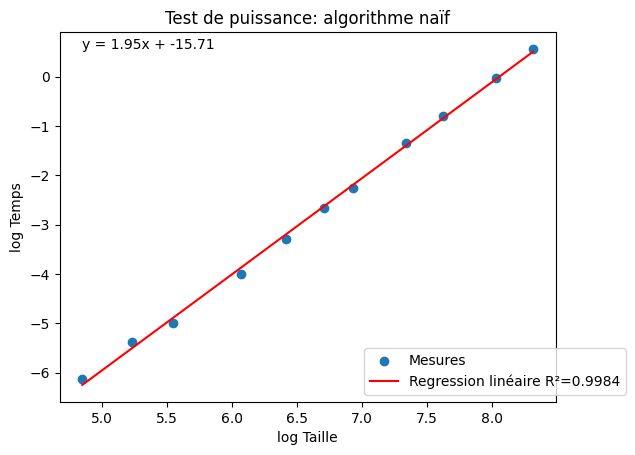

In [10]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(x):math.log(y) for x, y in measures.items() 
    }

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

On remarque que les points suivent de près la forme d'une droite et que la valeur du $R^2$ est très proche de 1, ce qui semble indiquer que la croissance du temps de calcul de l'algorithme naïf est polynomiale. Puisque la pente et l'ordonnée à l'origine sont respectivement 1,95 et -15,71 ; on peut déduire que le temps de calcul de l'algorithme semble suivre l'équation $y = e^{-15,71} \times x^{1,95}$. On peut remarquer que la pente se situe autour de 2, ce qui semble indiquer que la complexité de l'algorithme devrait se situer autour de O($n^2$).

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

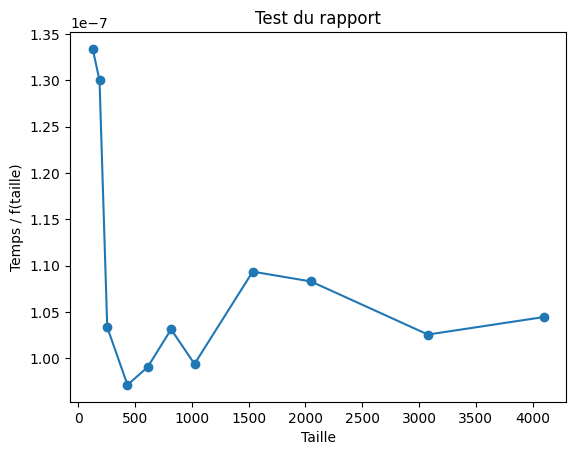

In [11]:
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        x : y / f(x) for x, y in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x ** 2

display_test_rapport(values_test_rapport(measures_bruteforce, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

À partir de la complexité théorique et du test de puissance, l'algorithme devrait avoir une complexité de O($n^2$), c'est pour cette raison que la fonction choisie soit $f(x) = x^2$. De plus, le test du rapport permettrait de confirmer si le temps de calcul de l'algorithme naïf peut être représenté par une fonction du second degré. À partir du graphique obtenu, on remarque que le rapport entre le temps de calcul et la fonction f(x) converge autour de 1,05e-7 au fil que les exemplaires augmente. Donc, on peut déduire que temps de calcul en fonction de la taille de l'exemplaire semble suivre l'équation y = 1,05e-7 $\times$ $x^2$.

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

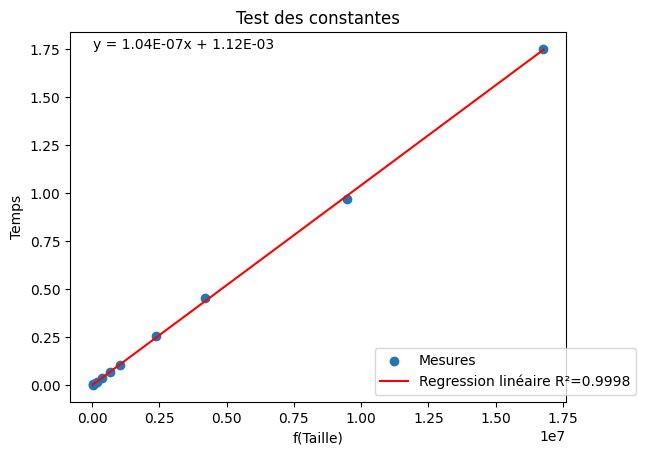

In [12]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(x) : y for x, y in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return x ** 2

display_test_constantes(values_test_constantes(measures_bruteforce, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Le temps de calcul de l'algorithme naïf en fonction de la taille de l'exemplaire semble avoir une complexité de O($n^2$), c'est pour cette raison que la fonction f(x) = $x^2$ a été choisie. À partir du graphique, on peut observer que le temps de calcul semble suivre de très près la courbe $y = c \times f(x) + b = 1,04e-7 \times x^2 + 0,00112$.

## Partie 2 : Algorithme diviser pour régner (5 pts)

<u>**Question 1.a):**</u> Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

In [33]:
def merge_skylines(left: list, right: list) -> list:
    skyline = []
    
    current_left_height = 0
    current_right_height = 0
    previous_point = (0, 0)
    next_point = (0, 0)

    i = j = 0

    while i < len(left) and j < len(right):
        if left[i][0] == right[j][0]:
            current_left_height, current_right_height = left[i][1], right[j][1]
            next_point = (left[i][0], max(current_left_height, current_right_height))
            i += 1
            j += 1
        
        elif left[i][0] < right[j][0]:
            current_left_height = left[i][1]
            next_point = (left[i][0], max(current_left_height, current_right_height))
            i += 1
        else:
            current_right_height = right[j][1]
            next_point = (right[j][0], max(current_left_height, current_right_height))
            j += 1

        if next_point[1] != previous_point[1]:
            skyline.append(next_point)
            previous_point = next_point
        
    while i < len(left):
        current_left_height = left[i][1]
        skyline.append((left[i][0], max(current_left_height, current_right_height)))
        i += 1

    while j < len(right):
        current_right_height = right[j][1]
        skyline.append((right[j][0], max(current_left_height, current_right_height)))
        j += 1
    
    return skyline

In [34]:
def skyline_divide_and_conquer(buildings):
    skyline = []
    # TODO: Implantez un algorithme diviser-pour-régner

    if len(buildings) > 1:
        mid = len(buildings) // 2

        left_skyline = skyline_divide_and_conquer(buildings[:mid])
        right_skyline = skyline_divide_and_conquer(buildings[mid:])

        skyline = merge_skylines(left_skyline, right_skyline)
    else:
        skyline = [(buildings[0][L], buildings[0][H]), (buildings[0][R], 0)]
                    
    return skyline

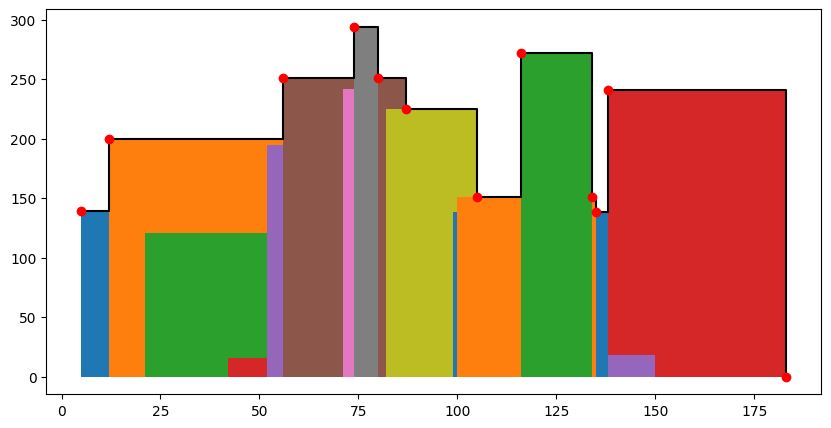

In [36]:
test_divide_and_conquer = generate_sample(15)

verification_plot(test_divide_and_conquer, skyline_divide_and_conquer(test_divide_and_conquer))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

Puisqu'on fait 2 appels récursifs par appel de fonction, qu'on divise par deux la taille de l'examplaire par appel de la fonction et que le traitement fait par chaque appel (au pire des cas) est en O(n) dû au merge_skylines qui itère une fois sur les skylines à fusionner, le temps d'exécution $T$ en fonction de la taille $n$ peut se représenter par : $T(n) = l \times T(n/b) = 2T(n/2) + cn^1$, où l=2, b=2 et k=1. Par le théorème général, puisque $l = 2 = b^k$, on peut déduire que la complexité est $\Theta(n \times \log n).$

### Mesures (seuil 1)

In [37]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(123456789, [434, 612, 818, 1024, 1536, 2048, 3078, 4096, 6144, 8192])

In [38]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)

In [41]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
434          0.0021934986114501955
612          0.00384674072265625
818          0.004237127304077148
1024         0.005183696746826172
1536         0.008048820495605468
2048         0.011428022384643554
3078         0.016314601898193358
4096         0.024661493301391602
6144         0.03630828857421875
8192         0.056113481521606445


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

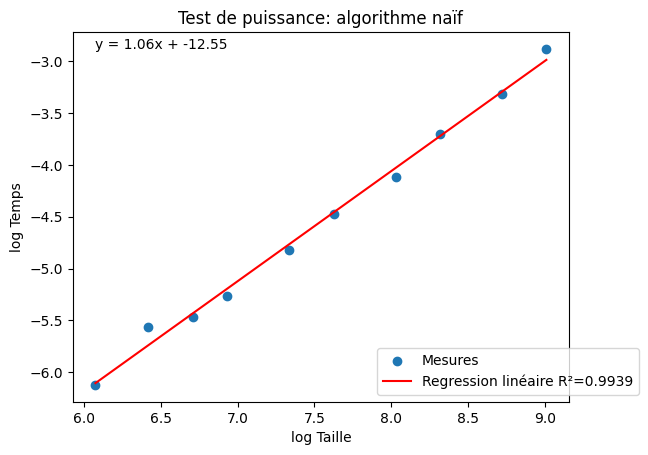

In [42]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: algorithme naïf")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Les points du graphiques semblent suivre de très près la forme d'un droite, ce qui semble indiquer que le taux de croissance est polynomiale. Puisque la pente est de 1,06; cela semble indiquer que la complexité de l'algorithme diviser pour régner devrait être autour de O($n^{1,06}$).

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

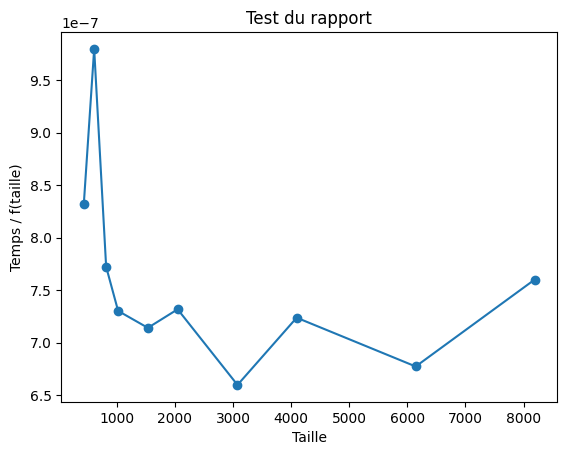

In [43]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Puisque la complexité théorique est de l'ordre de $O(n\log n)$, la fonction $f(x) = x \log x$ a été choisie. À partir du graphique obtenu, on peut remarquer une descente rapide entre les tailles d'exemplaire 600 à 1500. Ensuite, on remarque que le rapport du temps de calcul sur f(x) semble osciller autour de la valeur de 7e-7, ce qui semble indiquer que les valeurs se stabilisent autour de la valeur de 7e-7. Par conséquent, il semble avoir convergence. Cela implique que la complexité est non seulement supérieure à O(n), mais aussi de l'ordre de O($n \log n$).

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

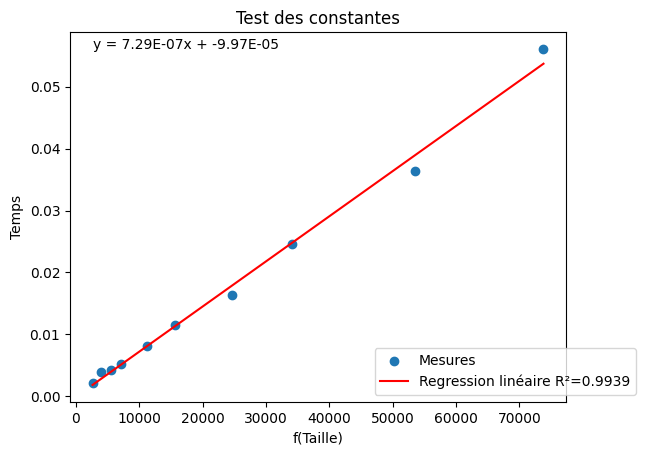

In [44]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

On remarque que les points semble suivre de très près la forme d'une droite, ce qui implique que le temps de calcul en fonction de la taille de l'exemplaire suit de très près la courbe $y = c \times f(x) + b = 7,29e-7 \times n \log n - 9,97e-5$.

## Partie 3 : Algorithme diviser pour régner (seuil arbitraire) (5 pts)

### Selection du seuil

<u>**Question 1.a):**</u> Modifiez l'algorithme précédent pour y ajouter un seuil de récursivité (e.g. `threshold`). En dessous de ce seuil, vous utiliserez l'algorithme naïf écrit précédemment.

In [45]:
def skyline_divide_and_conquer_threshold(buildings, threshold=1):
    if threshold is None:
        threshold = 1
        
    skyline = []
    # TODO: Implantez un algorithme diviser-pour-régner
    if threshold > len(buildings):
        return skyline_bruteforce(buildings)
    
    if len(buildings) > 1:
        mid = len(buildings) // 2

        left_skyline = skyline_divide_and_conquer_threshold(buildings[:mid], threshold)
        right_skyline = skyline_divide_and_conquer_threshold(buildings[mid:], threshold)

        skyline = merge_skylines(left_skyline, right_skyline)
    else:
        skyline = [(buildings[0][L], buildings[0][H]), (buildings[0][R], 0)]
                    
    return skyline

<u>**Question 1.b):**</u> Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [48]:
buildings_list = [generate_sample(1500) for x in range(1, 200)]

measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        buildings_list) # TODO: sélectionnez un exemplaire 
        for i in [4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 32, 64, 80] # TODO: testez une liste judicieuse de seuils
}

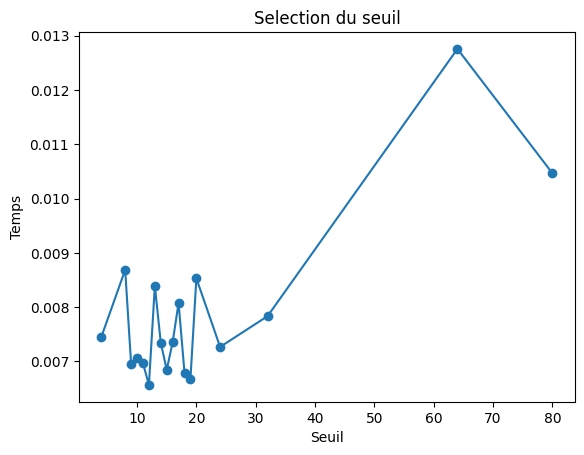

In [49]:
display_mesures_seuil(measures_threshold)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances ?

On remarque que le temps de calcul est minimal pour un seuil de 12. Lorsqu'on diminue le seuil par rapport au seuil optimal, le temps de calcul augmente, ceci s'explique par le fait que les gains de perfomances de l'algorithme naïf sont trop petits pour compenser le fait qu'on augmente le nombre d'appels de l'algorithme naïf, ce qui augmente le temps de calcul. Dans le cas inverse, lorsqu'on augmente le seuil par rapport au seuil optimal, l'algorithme naïf va consommer plus de temps de calcul que l'algorithme diviser pour régner, ce qui augmente le temps de calcul.

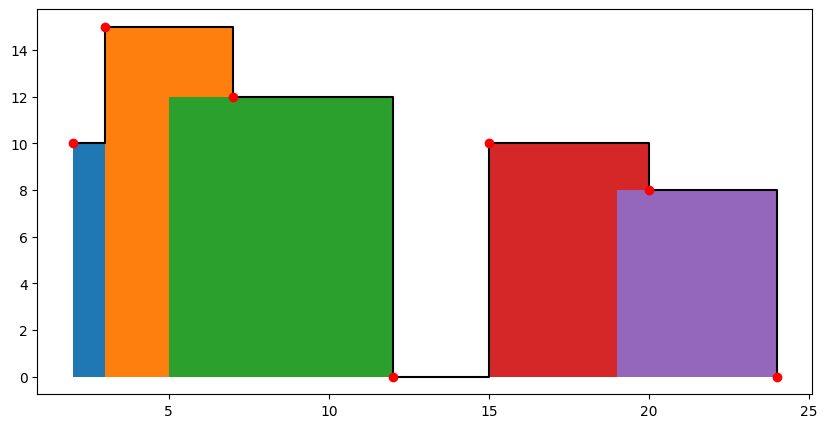

In [50]:
best_threshold = 12
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, best_threshold))

<u>**Question 1.d):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

L'algorithme fait deux appels récursifs, et à chaque appel récursif on divise par deux la taille de l'exemplaire. Et, le traitement fait par chaque appel est (dans le pire cas) en O(n), car soit on fusionne les skylines obtenues dans les fonctions récursives, ce qui est en O(n), soit on fait appel à l'algorithme naïf, ce qui est en O(1) parce qu'on appelle l'algorithme naïf avec au plus 12 exemplaires. Par conséquent, le temps de calcul $T$ en fonction de la taille d'exemplaire $n$ peut se représenter par : $T(n) = l \times T(n/b) = 2T(n/2) + cn^1$, où l=2, b=2 et k=1. Par le théorème général, puisque $l = 2 = b^k$, on peut déduire que la complexité est $\Theta(n \times \log n).$

### Mesures (seuil n)

In [51]:
measures_divide_best_threshold = measure_procedure(lambda sample : skyline_divide_and_conquer_threshold(sample, best_threshold), dataset)

In [52]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
434          0.0021663665771484374
612          0.0032127857208251952
818          0.003615570068359375
1024         0.004195356369018554
1536         0.007002687454223633
2048         0.008982133865356446
3078         0.014778232574462891
4096         0.0215425968170166
6144         0.03396520614624023
8192         0.043719148635864256


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

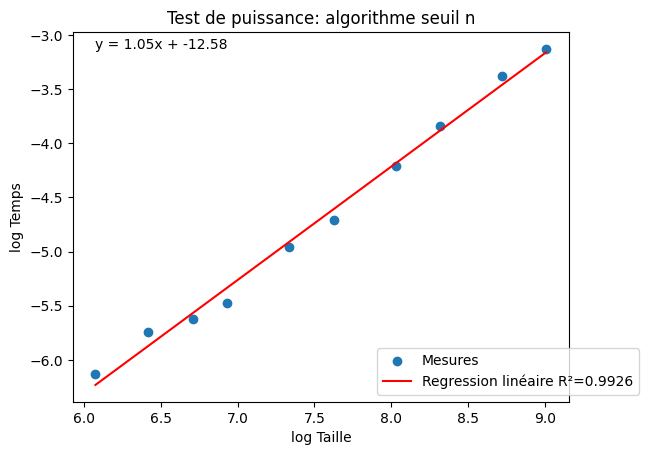

In [53]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

On remarque que les points dans le graphique suivent de très près la forme d'une droite. On peut conclure que la croissance du temps de calcul en fonction de la taille d'exemplaire est polynomiale.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

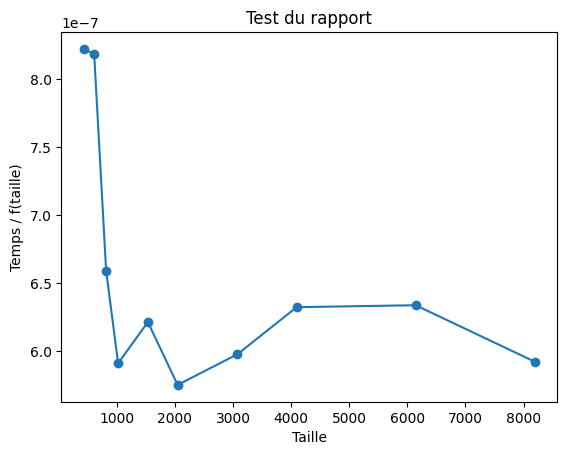

In [54]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

On observe que le rapport entre le temps de calcul et la fonction $f(x) = x \log x$ converge vers une valeur autour de 6e-7. On peut donc conclure que la complexité de l'algorithme diviser pour régner avec seuil est de $O(n \log n)$.

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

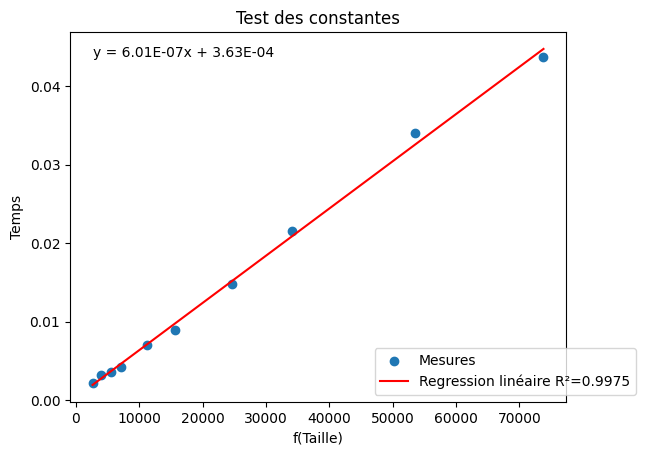

In [55]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

On remarque que les points du graphique suivent de très près la forme d'une droite. On peut conclure que le temps de calcul $y$ par rapport à taille de l'exemplaire $x$ suit l'équation : $y = c \times f(x) + b = 6,01e-7 \times x \log x + 3,63e-4$.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

Le seuil de récursivité permet d'accélérer l'algorithme diviser pour régner. Le seuil de récursivité représente la valeur où l'algorithme naïf consomme moins de temps de calcul que l'algorithme diviser pour régner.

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes.

L'algorithme naïf a une complexité de $O(n^2)$ alors que les algorithmes diviser pour régner ont une complexité $O(n \log n)$. Malgré le fait que la complexité de l'algorithme naïf est beaucoup plus grande que celle des algorithmes diviser pour régner, le temps de calcul de l'algorithme naïf est plus petit que l'algorithme diviser pour régner pour des tailles d'exemplaire entre 10 et 20. Pour des petites tailles d'exemplaires ou pour des situations où le temps de calcul n'est pas une priorité, on utilisera l'agorithme naïf. Pour le cas où on s'attend à traiter uniquement de grandes tailles d'exemplaires, on utilisera l'algorithme diviser pour régner. Dans le cas où on cherche les meilleurs performances en temps de calcul (peu importe la taille de l'exemplaire), on utilisera l'algorithme diviser pour régner avec seuil de récursivité.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.